In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../nonlin')
sys.path.append('../partion')
sys.path.append('../1D-difusion')

from aspen import aspen
from newton import newton

import partion
from partion import metrics1, metrics2, m1, m2, m3
import wrapper

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

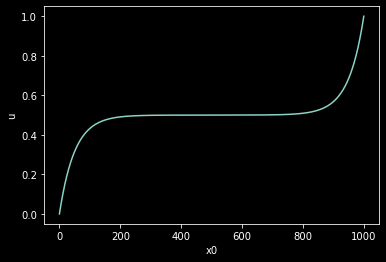

In [3]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100

D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1

x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

setInitial = lambda x: x#.setInitial(0.2, 1, 1) 
setSources = lambda x: x#.setSources([0.9], [-17.9])

In [4]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
solver_cl = one_phase(param, D, nl_solver)
X_cl, message, t_new = wrapper.calc(solver_cl, x0, bd1, bd2)

test started
verdict : OK
mean time : 72.52944922447205
mean newton iterations:  4.11


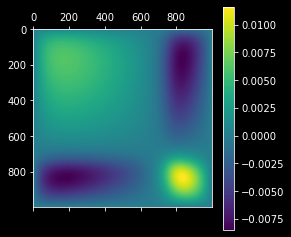

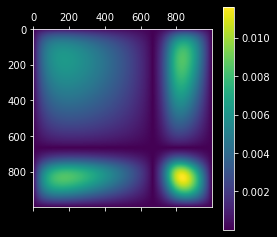

In [5]:
# we treet the value in time at particular coord as a variable
# let's visualize the covariance matrix of these varibles

cov_m = np.cov(X_cl)
cs = plt.matshow(cov_m)
cbar = plt.colorbar(cs)
plt.show()

cs = plt.matshow(np.abs(cov_m))
cbar = plt.colorbar(cs)
plt.show()

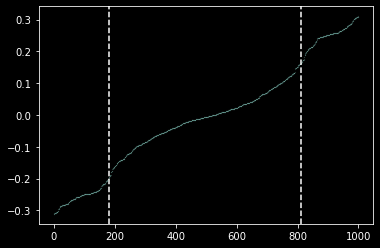

In [7]:
from sklearn.mixture import GaussianMixture

# spectral partioning approach
part = partion.spec_bis(np.abs(cov_m), inv = True)
part = np.sort(np.real(part))

plt.plot(np.arange(Nx), part, marker ='.', linestyle='', ms=0.2)

x_grid = np.arange(Nx)
data = np.stack((x_grid, part), axis= 0 ).T

borders = [180, 810]
for bd in borders:
    plt.axvline(bd, linestyle ='--')
plt.show()
    
borders = np.concatenate(([0], borders, [Nx]))

In [9]:
Nd = 3
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_1 = one_phase(param, D, nl_solver)
X, message, t_1 = wrapper.calc(solver_1, x0, bd1, bd2)

test started
verdict : OK
mean time : 63.1016800403595
mean aspen iterations:  1.08


--time comparision--
newton : 72.52944922447205
aspen, cov_m : 63.1016800403595


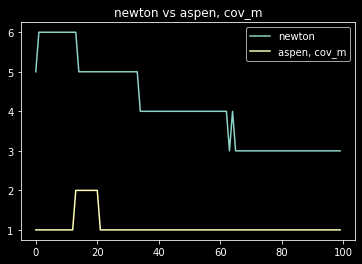

iters : [6.65 1.08 1.09]


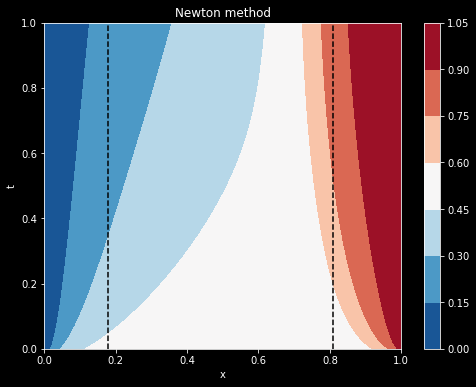

--time comparision--
newton : 72.52944922447205
aspen, cov_m : 63.1016800403595


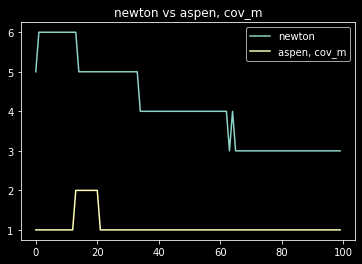

In [10]:
wrapper.compare([solver_cl, solver_1], ['newton', 'aspen, cov_m'])
wrapper.show_res(solver_1)
wrapper.compare([solver_cl, solver_1], ['newton', 'aspen, cov_m'])

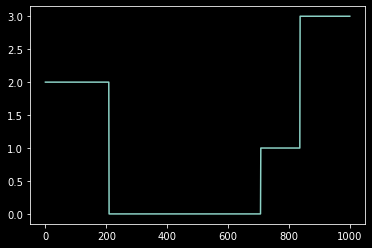

[   0  209  707  836 1000]


In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state = 0).fit(X_cl)
plt.plot(kmeans.labels_)
plt.show()
a = kmeans.labels_
borders = []
for i in range(1, Nx):
    if a[i] != a[i-1]:
        borders.append(i)
borders = np.concatenate(([0], borders, [Nx]))
print(borders)

test started
verdict : OK
mean time : 67.29071593284607
mean aspen iterations:  1.17
--time comparision--
cov_m : 63.1016800403595
k-means : 67.29071593284607


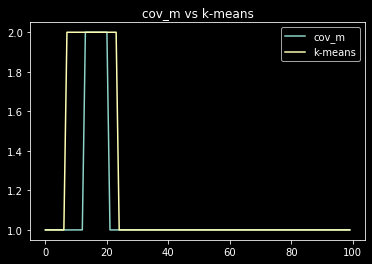

In [12]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_2 = one_phase(param, D, nl_solver)
X, message, t_1 = wrapper.calc(solver_2, x0, bd1, bd2)
wrapper.compare([solver_1, solver_2], ['cov_m', 'k-means'])